# NEURAL NETWORKS AND DEEP LEARNING

---
Scaramuzza Luca 2019132 - Homework 2
---


# Set up the environment

In [1]:
!pip install gym
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from collections import deque
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graph

In [2]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [3]:
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [4]:
def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Cart Pole gym environment

In [5]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self))
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
replay_mem = ReplayMemory(capacity=3)

print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(4, 4, 4, 4), (5, 5, 5, 5)]
[(5, 5, 5, 5), (4, 4, 4, 4)]
[(5, 5, 5, 5), (3, 3, 3, 3)]
[(5, 5, 5, 5), (4, 4, 4, 4)]
[(3, 3, 3, 3), (4, 4, 4, 4)]


# Policy network definition

In [7]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(state_space_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, action_space_dim)
        )

    def forward(self, x):
        return self.linear(x)

In [8]:
net = DQN(state_space_dim=4, action_space_dim=2)

# Exploration policies

## Epsilon-greedy policy

Define the policy

In [9]:
def choose_action_epsilon_greedy(net, state, epsilon):
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)
    best_action = int(net_out.argmax())
    action_space_dim = net_out.shape[-1]
    if random.random() < epsilon:
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        action = random.choice(non_optimal_actions)
    else:
        action = best_action
    return action, net_out.numpy()

Test the policy

In [10]:
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 0
Q-VALUES: [-0.02966618  0.04437566]


## Softmax policy

Define the policy

In [11]:
def choose_action_softmax(net, state, temperature):
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)
    temperature = max(temperature, 1e-8)
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out)
    return action, net_out.numpy()

Test the policy

In [12]:
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 0
Q-VALUES: [-0.02966618  0.04437566]


# Exploration profile

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

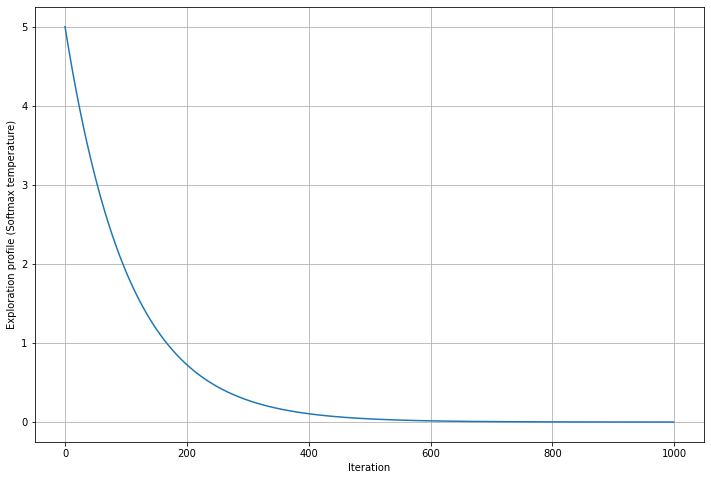

In [13]:
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6)
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

# Gym Environment (CartPole-v1)

## Set up the environment

In [14]:
env = gym.make('CartPole-v1')
env.seed(0)

state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


Test it with a random agent

In [15]:
env = gym.make('CartPole-v1') 
env.seed(0)

for num_episode in range(10): 
    state = env.reset()
    score = 0
    done = False
    while not done and score < 490:
        action = random.choice([0, 1])
        next_state, reward, done, info = env.step(action)
        env.render()
        score += reward 
        state = next_state
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()

EPISODE 1 - FINAL SCORE: 27.0
EPISODE 2 - FINAL SCORE: 24.0
EPISODE 3 - FINAL SCORE: 14.0
EPISODE 4 - FINAL SCORE: 19.0
EPISODE 5 - FINAL SCORE: 38.0
EPISODE 6 - FINAL SCORE: 16.0
EPISODE 7 - FINAL SCORE: 38.0
EPISODE 8 - FINAL SCORE: 12.0
EPISODE 9 - FINAL SCORE: 43.0
EPISODE 10 - FINAL SCORE: 30.0


## Network update

### Initialization

In [16]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

gamma = 0.99
replay_memory_capacity = 10000
lr = 1e-2
target_net_update_steps = 10 
batch_size = 128
bad_state_penalty = 0
min_samples_for_training = 1000

In [17]:
replay_mem = ReplayMemory(replay_memory_capacity)    

policy_net = DQN(state_space_dim, action_space_dim)

target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

loss_fn = nn.SmoothL1Loss()

### Update function

In [18]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)
    states = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards = torch.tensor([s[3] for s in batch], dtype=torch.float32)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)
    policy_net.train()
    q_values = policy_net(states)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape
    loss = loss_fn(state_action_values, expected_state_action_values)
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## Training loop

In [19]:
env = gym.make('CartPole-v1') 
env.seed(0)

scores=[]
last_scores=deque()

for episode_num, tau in enumerate(tqdm(exploration_profile)):
    state = env.reset()
    score = 0
    done = False
    while not done:
        action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
        next_state, reward, done, info = env.step(action)
        pos_weight = 1
        reward = reward - pos_weight * np.abs(state[0]) 
        score += 1
        if done:
            reward += bad_state_penalty
            next_state = None
        replay_mem.push(state, action, next_state, reward)
        if len(replay_mem) > min_samples_for_training:
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)
        state = next_state
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    scores.append(score)
    last_scores.append(score)
    if len(last_scores)>12:last_scores.popleft()
    if sum(last_scores)//12==500: break
env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  after removing the cwd from sys.path.


EPISODE: 44 - FINAL SCORE: 35 - Temperature: 3.300925656226998
EPISODE: 45 - FINAL SCORE: 18 - Temperature: 3.2692032590398465
EPISODE: 46 - FINAL SCORE: 23 - Temperature: 3.237785718910413
EPISODE: 47 - FINAL SCORE: 20 - Temperature: 3.206670106116043
EPISODE: 48 - FINAL SCORE: 16 - Temperature: 3.175853519089164
EPISODE: 49 - FINAL SCORE: 26 - Temperature: 3.145333084146709
EPISODE: 50 - FINAL SCORE: 14 - Temperature: 3.115105955222141
Updating target network...
EPISODE: 51 - FINAL SCORE: 52 - Temperature: 3.0851693136000553
EPISODE: 52 - FINAL SCORE: 17 - Temperature: 3.0555203676533305
EPISODE: 53 - FINAL SCORE: 37 - Temperature: 3.0261563525828072
EPISODE: 54 - FINAL SCORE: 14 - Temperature: 2.9970745301594635
EPISODE: 55 - FINAL SCORE: 18 - Temperature: 2.9682721884690775
EPISODE: 56 - FINAL SCORE: 43 - Temperature: 2.939746641659333
EPISODE: 57 - FINAL SCORE: 20 - Temperature: 2.911495229689364
EPISODE: 58 - FINAL SCORE: 17 - Temperature: 2.8835153180817
EPISODE: 59 - FINAL SCOR

## Plot

Text(0, 0.5, 'Scores')

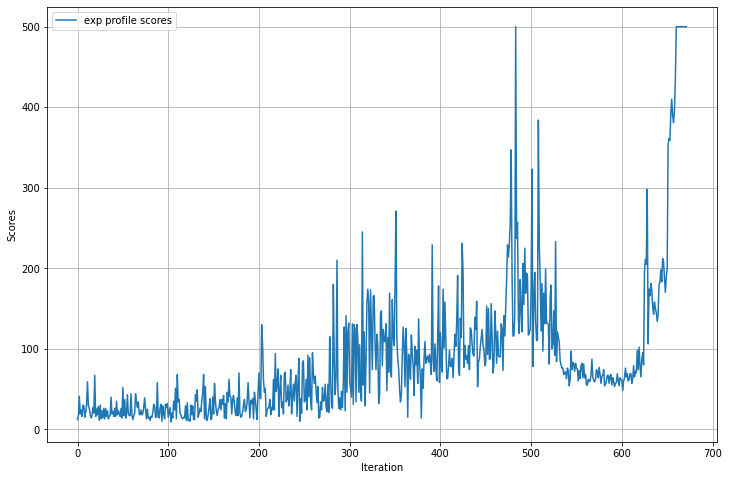

In [20]:
plt.figure(figsize=(12,8))
plt.plot(scores, label='exp profile scores')
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Scores')

## Final test

In [21]:
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

for num_episode in range(10): 
    state = env.reset()
    score = 0
    done = False
    while not done:
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        next_state, reward, done, info = env.step(action)
        env.render()
        score += reward 
        state = next_state
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [22]:
show_videos()


SHOWING VIDEO video/openaigym.video.0.6120.video000000.mp4



SHOWING VIDEO video/openaigym.video.0.6120.video000001.mp4



SHOWING VIDEO video/openaigym.video.0.6120.video000002.mp4



SHOWING VIDEO video/openaigym.video.0.6120.video000003.mp4



SHOWING VIDEO video/openaigym.video.0.6120.video000004.mp4



SHOWING VIDEO video/openaigym.video.0.6120.video000005.mp4



SHOWING VIDEO video/openaigym.video.0.6120.video000006.mp4



SHOWING VIDEO video/openaigym.video.0.6120.video000007.mp4



SHOWING VIDEO video/openaigym.video.0.6120.video000008.mp4



SHOWING VIDEO video/openaigym.video.0.6120.video000009.mp4


# MountainCar-v0 Gym

## Set up the environment

In [23]:
env = gym.make('MountainCar-v0')

env.seed(0)

state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 2
ACTION SPACE SIZE: 3


In [24]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

gamma = 0.95
replay_memory_capacity = 10000
lr = 1e-1
target_net_update_steps = 5
batch_size = 64
bad_state_penalty = 0 
min_samples_for_training = 1000

Initialize the replay memory

In [25]:
replay_mem = ReplayMemory(replay_memory_capacity)    

policy_net = DQN(state_space_dim, action_space_dim)

target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

loss_fn = nn.SmoothL1Loss()

## Train loop

In [26]:
env = gym.make('MountainCar-v0') 
env.seed(0)

scores=[]
last_scores=deque()

for episode_num, tau in enumerate(tqdm(exploration_profile)):
    state = env.reset()
    score = 0
    done = False
    while not done:
        action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
        next_state, reward, done, info = env.step(action)
        pos_weight = 6
        if (action ==0 and state[1]<0) or (action==2 and state[1]>0):
            reward= reward + pos_weight * np.abs(state[0]+0.5)
        else:reward= reward-2
        score=state[0]
        replay_mem.push(state, action, next_state, reward)
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)
        state = next_state
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau} - REW: {reward}") # Print the final score
    scores.append(score)
    last_scores.append(score)
    if len(last_scores)>10:last_scores.popleft()
    if sum(last_scores)/10>=0.48: break
env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -0.46158377387638805 - Temperature: 5.0 - REW: -3.0
EPISODE: 2 - FINAL SCORE: -0.5427428986061521 - Temperature: 4.951949240166454 - REW: -0.7435426083630874
EPISODE: 3 - FINAL SCORE: -0.5302125688191489 - Temperature: 4.904360255437024 - REW: -0.8187245870851065
EPISODE: 4 - FINAL SCORE: -0.5015577286964845 - Temperature: 4.857228608082785 - REW: -3.0
EPISODE: 5 - FINAL SCORE: -0.48137046894444135 - Temperature: 4.810549903022062 - REW: -3.0
Updating target network...
EPISODE: 6 - FINAL SCORE: -0.3880695175792373 - Temperature: 4.764319787410582 - REW: -3.0
EPISODE: 7 - FINAL SCORE: -0.6689369382735617 - Temperature: 4.7185339502355665 - REW: 0.013621629641370259
EPISODE: 8 - FINAL SCORE: -0.6607742975312099 - Temperature: 4.673188121913726 - REW: -3.0
EPISODE: 9 - FINAL SCORE: -0.50646172087311 - Temperature: 4.628278073893115 - REW: -0.9612296747613398
EPISODE: 10 - FINAL SCORE: -0.4403970205752435 - Temperature: 4.583799618258813

## Plot

Text(0, 0.5, 'Scores')

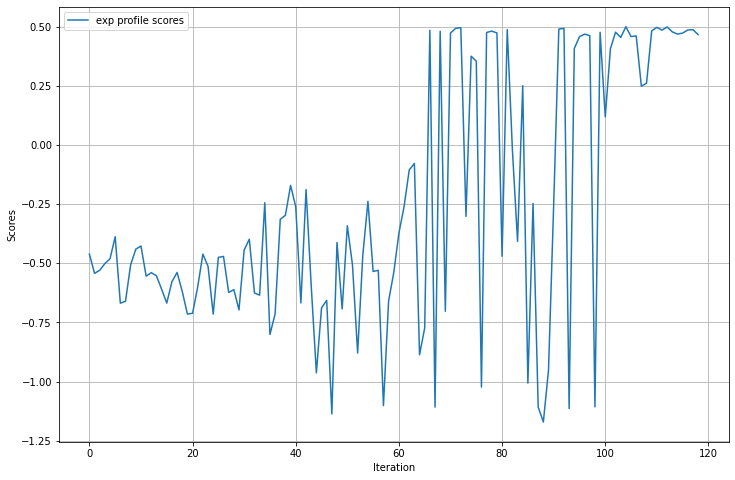

In [27]:
plt.figure(figsize=(12,8))
plt.plot(scores, label='exp profile scores')
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Scores')

## Test

In [28]:
env = gym.make('MountainCar-v0') 
env.seed(1)
env = wrap_env(env, video_callable=lambda episode_id: True)
for num_episode in range(10): 
    state = env.reset()
    score = 0
    done = False
    while not done:
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        next_state, reward, done, info = env.step(action)
        env.render()
        score = next_state[0]
        state = next_state
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: -0.35206311008956653
EPISODE 2 - FINAL SCORE: 0.5280471388826753
EPISODE 3 - FINAL SCORE: 0.5368577983788596
EPISODE 4 - FINAL SCORE: 0.5368577983788596
EPISODE 5 - FINAL SCORE: -0.3467930906656754
EPISODE 6 - FINAL SCORE: 0.5368577983788596
EPISODE 7 - FINAL SCORE: 0.5368577983788596
EPISODE 8 - FINAL SCORE: 0.5278935599496921
EPISODE 9 - FINAL SCORE: -0.3331530030333552
EPISODE 10 - FINAL SCORE: 0.5185803841283196


In [30]:
show_videos()


SHOWING VIDEO video/openaigym.video.1.6120.video000000.mp4



SHOWING VIDEO video/openaigym.video.1.6120.video000001.mp4



SHOWING VIDEO video/openaigym.video.1.6120.video000002.mp4



SHOWING VIDEO video/openaigym.video.1.6120.video000003.mp4



SHOWING VIDEO video/openaigym.video.1.6120.video000004.mp4



SHOWING VIDEO video/openaigym.video.1.6120.video000005.mp4



SHOWING VIDEO video/openaigym.video.1.6120.video000006.mp4



SHOWING VIDEO video/openaigym.video.1.6120.video000007.mp4



SHOWING VIDEO video/openaigym.video.1.6120.video000008.mp4



SHOWING VIDEO video/openaigym.video.1.6120.video000009.mp4
